In [ ]:
!pip install itkwidgets
!pip install itk 

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nib                                                     
import itk                                                                
import itkwidgets
import cv2
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate

%matplotlib inline
import seaborn as sns

from tensorflow import keras
from keras import layers


import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf

from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.utils import plot_model
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import os
from google.colab import drive
from keras.layers import Input, Conv3D, concatenate,GlobalAveragePooling3D, Dense, Reshape, multiply, Activation

In [ ]:
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")
os.listdir("/content/drive/My Drive")

Mounted at /content/drive


['Colab Notebooks',
 'w02_MLP_IMDB.ipynb',
 'Assessment1 (1) (1) (1) (1) (1) (1) (1) (1) (1) (1) (1) (1).ipynb',
 'Untitled0.ipynb',
 'BB2021',
 'training.log',
 'training_result_2018.png']

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=1e-5):
    """
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    numerator = 2 * K.sum(y_true * y_pred, axis=(0, 1, 2, 3)) + epsilon
    denominator = K.sum(K.square(y_true), axis=(0, 1, 2, 3)) + K.sum(K.square(y_pred), axis=(0, 1, 2, 3)) + epsilon
    return K.mean(numerator / denominator)


# inspired by https://github.com/keras-team/keras/issues/9395

def dice_coef_nec(y_true, y_pred, epsilon=1e-6):
    necrotic_intersection = K.sum(K.abs(y_true[0, :, :, :, 1] * y_pred[0, :, :, :, 1]))
    necrotic_denominator = K.sum(y_true[0,:,:,:,1] * y_true[0,:,:,:,1] ) + K.sum(y_pred[0,:,:,:,1] * y_pred[0,:,:,:,1]) + epsilon
    necrotic = (2. * necrotic_intersection) / necrotic_denominator
    return necrotic

def dice_coef_ede(y_true, y_pred, epsilon=1e-6):
    edema_intersection = K.sum(K.abs(y_true[0, :, :, :, 2] * y_pred[0, :, :, :, 2]))
    edema_denominator = K.sum(y_true[0,:,:,:,2] * y_true[0,:,:,:,2] ) + K.sum(y_pred[0,:,:,:,2] * y_pred[0,:,:,:,2]) + epsilon
    edema = (2. * edema_intersection) / edema_denominator
    return edema

def dice_coef_enh(y_true, y_pred, epsilon=1e-6):
    enhancing_intersection = K.sum(K.abs(y_true[0, :, :, :, 3] * y_pred[0, :, :, :, 3]))
    enhancing_denominator = K.sum(y_true[0,:,:,:,3] * y_true[0,:,:,:,3] ) + K.sum(y_pred[0,:,:,:,3] * y_pred[0,:,:,:,3]) + epsilon
    enhancing = (2. * enhancing_intersection) / enhancing_denominator
    return enhancing    


def precision(y_true, y_pred, epsilon=1e-7):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_FP = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return TP / (TP_FP + epsilon)


def sensitivity(y_true, y_pred, epsilon=1e-7):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_FN = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (TP_FN+ epsilon)

def specificity(y_true, y_pred, epsilon=1e-7):
    TN = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    TN_FP = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return TN / (TN_FP + epsilon)

In [ ]:
# the selected dataset called train_images_mini
path = 'BB2021/train_images_mini'
directory = [os.path.join(path, f.name) for f in os.scandir(path) if f.is_dir()]

def path_Ids(directory_ls):
    return [dir.split('/')[-1] for dir in directory_ls]

ids = path_Ids(directory)

train_ids, test_ids = train_test_split(ids,test_size=0.1, random_state =1) 
train_ids, val_ids = train_test_split(ids,test_size=0.1, random_state =1) 

In [ ]:
segment_class = {
    i: cla for i, cla in enumerate(['Not tumor', 'Necrotic/Core', 'Edema', 'Enhancing'])
}



volume_slices = 128 
starting_volume = 22 # first slice of volume 
img_size=128

In [ ]:
class DataGenerator(tf.compat.v1.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(img_size,img_size), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*volume_slices, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*volume_slices, 128, 128))

        
        # Generate data
        for c, i in enumerate(batch_ids):
            case_path = os.path.join(path, i)
            data_paths = [os.path.join(case_path, f"{i}_{x}.nii.gz") for x in ["flair", "t1ce", "seg"]]
            flair, ce, seg = [nib.load(data_path).get_fdata() for data_path in data_paths]
            
            for j in range(volume_slices):
                slice_idx = j + (volume_slices * c)
                X[slice_idx,:,:,0] = cv2.resize(flair[:,:,j+starting_volume], (img_size,img_size))

                X[slice_idx,:,:,1] = cv2.resize(ce[:,:,j+starting_volume], (img_size,img_size))
             
             
                y[slice_idx,:,:] = cv2.resize(seg[:,:,j+starting_volume], (img_size,img_size))

        X = X.reshape(1,128,128,128,2)
        y = y.reshape(1,128,128,128)
        # Generate masks
        y = np.where(y==4, 3, y);
        y = tf.one_hot(y, 4);

        return X/np.max(X), y
        
training_data = DataGenerator(train_ids)
valid_data = DataGenerator(val_ids)
test_data = DataGenerator(test_ids)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)]

### 3 * 3 * 3  Conv 

In [ ]:
#3*3 Conv stride = 1 
def conv_bn_PReLU_drop(input_mat,num_filters,batch_norm):

    X = Conv3D(num_filters, kernel_size=(3,3,3),strides=(1,1,1),padding= 'same')(input_mat)
    if batch_norm:
        X = BatchNormalization()(X)
  
    X = Activation('PReLU')(X)
    X = Dropout(rate=0.2)(X)
    return X

### 2 * 2 * 2 down/up sampling

In [ ]:
#Down_cov(Sampling) 
def Down_cov(input_mat,num_filters,batch_norm):
    X = Conv3D(num_filters,kernel_size=(2,2,2),strides=(2,2,2),padding='same')(input_mat)
    if batch_norm:
        X = BatchNormalization()(X)
  
    X = Activation('PReLU')(X)
    X = Dropout(rate=0.2)(X)
    return X

In [ ]:
#UP_Cov(Sampling) 
def UP_cov(input_mat,num_filters):
    
    X = Conv3DTranspose(num_filters,kernel_size=(2,2,2),strides=(2,2,2),padding='same')(input_mat)
    X = Activation('PReLU')(X)
    return X

### residual connection

In [ ]:
def resnet_Add(x1, x2):
    if x1.shape[-1] != x2.shape[-1]:
        # Option A: Zero-padding
        x1 = tf.pad(x1, [[0, 0], [0, 0], [0, 0], [0, 0], [x2.shape[-1] - x1.shape[-1], 0]])
    
    residual_connection = tf.add(x1, x2)   
    return residual_connection    
       

In [ ]:
def concatenate(x1, x2):
    """
    concat x1 and x2
    :param x1:
    :param x2:
    :return:
    """
    x1_shape = list(x1.shape)
    x2_shape = list(x2.shape)
    # offsets for the top left corner of the crop
    offsets = [(x1_shape[i] - x2_shape[i]) // 2 if i != 0 and i != 4 else 0 for i in range(len(x1_shape))]
    size = [-1] + x2_shape[1:4] + [-1]
    x1_crop = tf.slice(x1, offsets, size)
    
    return tf.concat([x1_crop, x2], 4)

### SE_Net:Squeeze-and-Excitation Networks

In [ ]:
def squeeze_excitation_model(x, out_dim, ratio=4):
            squeeze = Reshape(target_shape=(1, 1, 1, out_dim))(GlobalAveragePooling3D()(x))
            # Two fully connected layers
            excitation = Dense(units=out_dim // ratio, activation='relu')(squeeze)
            excitation = Dense(units=out_dim, activation='sigmoid')(excitation)
            # Scale the input
            scale = multiply([x, excitation])
            
            return scale

# SE_VNet_3d

In [ ]:
def SEVnet_3d(input_img, n_filters = 8, batch_norm = True):

    #channels = 16
    c0 = conv_bn_PReLU_drop(input_img, n_filters*1, True)
    
    c1 = conv_bn_PReLU_drop(input_img, n_filters*1, True)
    c1 = squeeze_excitation_model(c1, out_dim=n_filters*1)
    c1 = resnet_Add(c0,c1)
    # down sampling 1
    d1 = Down_cov(c1, n_filters*2, True)
    
    #layer 2
    c2 = conv_bn_PReLU_drop(d1 , n_filters*2,True)
    c2 = conv_bn_PReLU_drop(c2 , n_filters*2,True)
    c2 = squeeze_excitation_model(c2, out_dim=n_filters*2)
    c2 = resnet_Add(d1,c2)
    # down sampling 2
    d2 = Down_cov(c2, n_filters*4, True) 
    
    #layer 3
    c3 = conv_bn_PReLU_drop(d2 , n_filters*4,True)
    c3 = conv_bn_PReLU_drop(c3 , n_filters*4,True)
    c3 = conv_bn_PReLU_drop(c3 , n_filters*4,True)
    c3 = squeeze_excitation_model(c3, out_dim=n_filters*4)
    c3 = resnet_Add(d2,c3)
    # down sampling 3
    d3 = Down_cov(c3, n_filters*8, True)
    
    #layer 4
    c4 = conv_bn_PReLU_drop(d3 , n_filters*8,True)
    c4 = conv_bn_PReLU_drop(c4 , n_filters*8,True)
    c4 = conv_bn_PReLU_drop(c4 , n_filters*8,True)
    c4 = squeeze_excitation_model(c4, out_dim=n_filters*8)
    c4 = resnet_Add(d3,c4)
    # down sampling 4
    d4 = Down_cov(c4, n_filters*16, True)
  
    #layer 5
    c5 = conv_bn_PReLU_drop(d4 , n_filters*16,True)
    c5 = conv_bn_PReLU_drop(c5 , n_filters*16,True)
    c5 = conv_bn_PReLU_drop(c5 , n_filters*16,True)
    c5 = squeeze_excitation_model(c5, out_dim=n_filters*16)
    c5 = resnet_Add(d4,c5)
    
    # UP sampling 1
    u1 = UP_cov(c5, n_filters*16)
    
    #layer 6
    c6 = concatenate(c4, u1)
    
    c6 = conv_bn_PReLU_drop(c6 , n_filters*16,True)
    c6 = conv_bn_PReLU_drop(c6 , n_filters*16,True)
    c6 = conv_bn_PReLU_drop(c6 , n_filters*16,True)
    c6 = squeeze_excitation_model(c6, out_dim=n_filters*16) 
    c6 = resnet_Add(u1,c6) 
    # UP sampling 2
    u2 = UP_cov(c6, n_filters*8)
    
    #layer 7
    c7 = concatenate(c3, u2)
    
    c7 = conv_bn_PReLU_drop(c7 , n_filters*8,True)
    c7 = conv_bn_PReLU_drop(c7 , n_filters*8,True)
    c7 = conv_bn_PReLU_drop(c7 , n_filters*8,True)
    c7 = squeeze_excitation_model(c7, out_dim=n_filters*8)
    c7 = resnet_Add(u2,c7) 
    # UP sampling 3
    u3 = UP_cov(c7, n_filters*4)
    
    #layer 8
    c8 = concatenate(c2, u3)
    
    c8 = conv_bn_PReLU_drop(c8 , n_filters*4,True)
    c8 = conv_bn_PReLU_drop(c8 , n_filters*4,True)
    c8 = conv_bn_PReLU_drop(c8 , n_filters*4,True)
    c8 = squeeze_excitation_model(c8, out_dim=n_filters*4)
    c8 = resnet_Add(u3,c8) 
    # UP sampling 4
    u4 = UP_cov(c8, n_filters*2)
    
    
    #layer 9
    c9 = concatenate(c1, u4)
    
    c9 = conv_bn_PReLU_drop(c9 , n_filters*2,True)
    c9 = conv_bn_PReLU_drop(c9 , n_filters*2,True)
    c9 = conv_bn_PReLU_drop(c9 , n_filters*2,True)
    c9 = squeeze_excitation_model(c9, out_dim=n_filters*2) 
    c9 = resnet_Add(u4,c9) 
    
    #output layer filter
    #kernel_size = 1*1*1, 
    outputs = Conv3D(4, (1,1,1), activation='softmax')(c9)

    model = Model(inputs=input_img, outputs=outputs)

    return model

In [ ]:
input_layer = Input((128,img_size, img_size, 2))

model = SEVnet_3d(input_layer)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), precision, sensitivity, specificity,dice_coef,dice_coef_nec,dice_coef_ede, dice_coef_enh ] )


In [ ]:
history =  model.fit(training_data,
                     epochs=10,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_data
                     ) 

Epoch 1/10
90/90 [==============================] - 532s 6s/step - loss: 0.3304 - accuracy: 0.8749 - mean_io_u: 0.5350 - precision: 0.8488 - sensitivity: 0.7787 - specificity: 0.9948 - dice_coef: 0.3661 - dice_coef_nec: 0.1187 - dice_coef_ede: 0.3842 - dice_coef_enh: 0.0677 - val_loss: 0.5519 - val_accuracy: 0.9844 - val_mean_io_u: 0.9502 - val_precision: 0.9844 - val_sensitivity: 0.9844 - val_specificity: 0.9948 - val_dice_coef: 0.2480 - val_dice_coef_nec: 1.0419e-05 - val_dice_coef_ede: 1.3011e-05 - val_dice_coef_enh: 2.4183e-06 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 100s 1s/step - loss: 0.0289 - accuracy: 0.9908 - mean_io_u: 0.6171 - precision: 0.9935 - sensitivity: 0.9887 - specificity: 0.9979 - dice_coef: 0.5225 - dice_coef_nec: 0.1909 - dice_coef_ede: 0.6066 - dice_coef_enh: 0.2946 - val_loss: 0.2095 - val_accuracy: 0.9844 - val_mean_io_u: 0.6054 - val_precision: 0.9844 - val_sensitivity: 0.9844 - val_specificity: 0.9948 - val_dice_coef: 0.2482 - val_dic

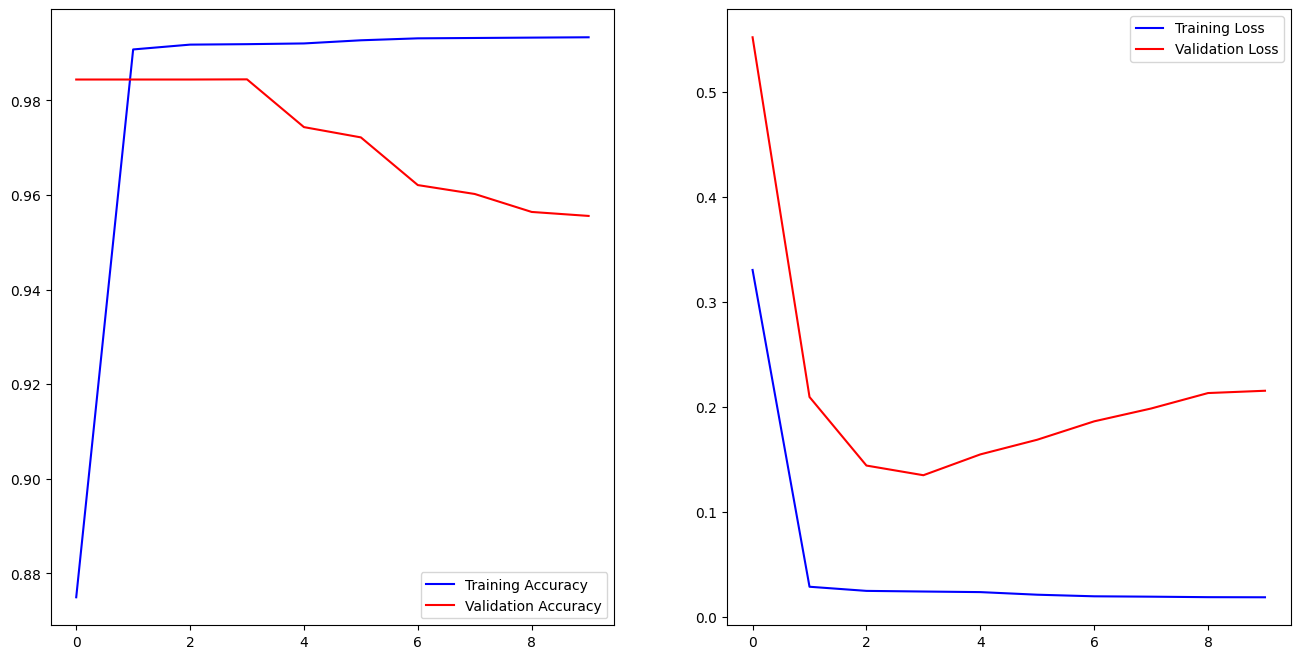

In [23]:
hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

plt.show()

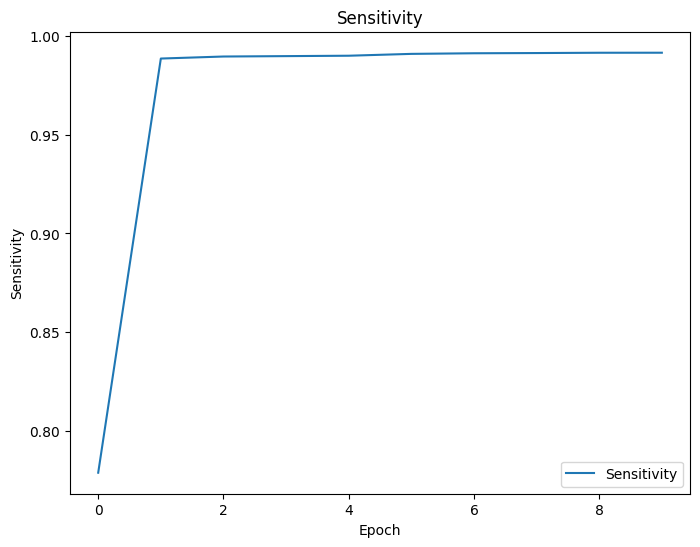

In [24]:
fig = plt.figure(figsize=(8, 6))


ax = fig.add_subplot(111)
ax.set_title('Sensitivity')
ax.set_xlabel('Epoch')
ax.set_ylabel('Sensitivity')

epochs = np.arange(len(hist['sensitivity']))
ax.plot(epochs, hist['sensitivity'], label='Sensitivity')

ax.legend()

plt.show()

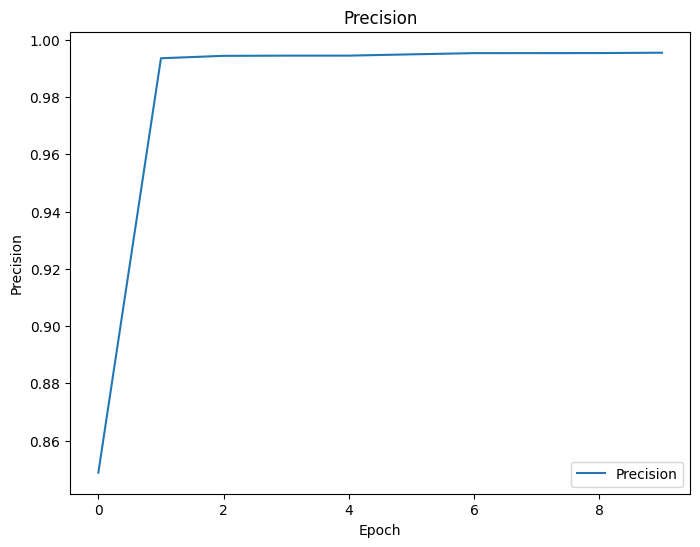

In [25]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
ax.set_title('Precision')
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')

epochs = np.arange(len(hist['precision']))
ax.plot(epochs, hist['precision'], label='Precision')

ax.legend()

plt.show()

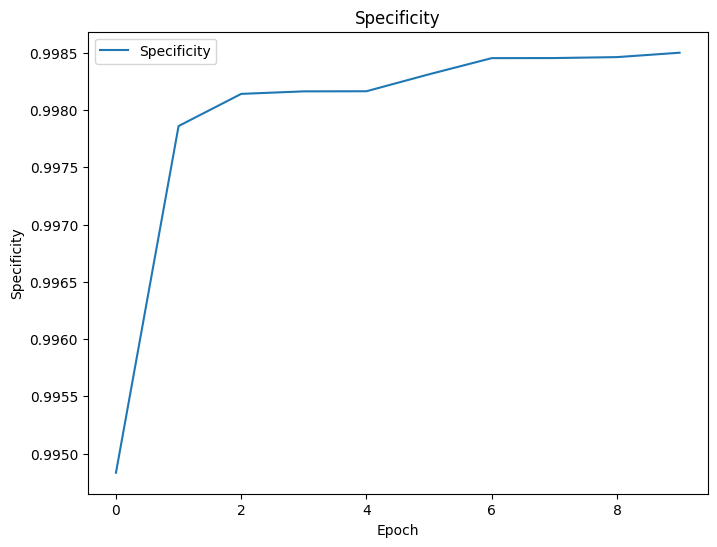

In [26]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
ax.set_title('Specificity')
ax.set_xlabel('Epoch')
ax.set_ylabel('Specificity')

epochs = np.arange(len(hist['specificity']))
ax.plot(epochs, hist['specificity'], label='Specificity')

ax.legend()

plt.show()